# Introduction

## Recommendation System - Indonesia Tourism

by: Sri Agung Tirtayasa

dataset: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination

# Preparation

In [1]:
# Install kaggle library

!pip install kaggle -q

In [2]:
# Import all required library

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [3]:
# Upload kaggle credentials

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sriagungtirtayasa","key":"339f49a0ad353302cde8d1340eaa83b8"}'}

In [4]:
# Make directory for credentials and dataset

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!mkdir datasets

In [5]:
# Download dataset link: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination

!kaggle datasets download -d aprabowo/indonesia-tourism-destination

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 38.2MB/s]


In [6]:
!unzip indonesia-tourism-destination.zip -d datasets

Archive:  indonesia-tourism-destination.zip
  inflating: datasets/package_tourism.csv  
  inflating: datasets/tourism_rating.csv  
  inflating: datasets/tourism_with_id.csv  
  inflating: datasets/user.csv       


In [7]:
# Load all dataset

df_package = pd.read_csv('datasets/package_tourism.csv')
df_tourism = pd.read_csv('datasets/tourism_with_id.csv')
df_user = pd.read_csv('datasets/user.csv')
df_transaction = pd.read_csv('datasets/tourism_rating.csv')

# Data Understanding

Dataset ini terdiri dari 4 file csv

package_tourism.csv = dataset daftar paket wisata

Features:
- Package: ID dari paket
- City: Kota paket wisata
- PlaceTourism1: Tempat paket wisata 1
- PlaceTourism2: Tempat paket wisata 2
- PlaceTourism3: Tempat paket wisata 3
- PlaceTourism4: Tempat paket wisata 4
- PlaceTourism5: Tempat paket wisata 5


tourism_with_id.csv = dataset daftar tempat wisata

Features:
- Place_Id: ID dari tempat wisata
- Place_Name: Nama dari tempat wisata
- Description: Deskripsi tempat wisata
- Category: Kategori tempat wisata
- City: Kota tempat wisata
- Price: Harga tempat wisata
- Rating: Rating tempat wisata
- Time_Minute: -
- Coordinate: Titik koordinat dalam bentuk json 'lat' dan 'lng'
- Lat: Latitude
- Long: Longitude


user.csv = daftar user

Features
- User_Id: ID dari user
- Location: Kota dan provinsi tempat tinggal user
- Age: Umur user

tourism_rating.csv = daftar rating tempat

Features:
- Place_Id: ID dari tempat wisata
- User_Id: ID dari user
- Place_Ratings: Rating dari user ke tempat wisata



In [8]:
df_package.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Package         100 non-null    int64 
 1   City            100 non-null    object
 2   Place_Tourism1  100 non-null    object
 3   Place_Tourism2  100 non-null    object
 4   Place_Tourism3  100 non-null    object
 5   Place_Tourism4  66 non-null     object
 6   Place_Tourism5  39 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


In [9]:
df_package.head()

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,NaN


In [10]:
df_package.reset_index()
df_package.set_index('Package')
df_package.fillna('')

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,,
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,,
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,,
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,
...,...,...,...,...,...,...,...
95,96,Surabaya,Ekowisata Mangrove Wonorejo,Taman Harmoni Keputih,Taman Kunang-Kunang,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank
96,97,Surabaya,Ciputra Waterpark,Kenjeran Park,Kebun Binatang Surabaya,Food Junction Grand Pakuwon,| Atlantis Land Surabaya
97,98,Surabaya,Museum Kesehatan Dr. Adhyatma,Patung Buddha Empat Rupa,Taman Hiburan Rakyat,Taman Bungkul,Taman Flora Bratang Surabaya
98,99,Surabaya,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank,Surabaya Museum (Gedung Siola),Museum Mpu Tantular,Taman Air Mancur Menari Kenjeran


In [11]:
df_tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [12]:
df_tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [13]:
df_tourism.drop(['Unnamed: 11', 'Unnamed: 12', 'Time_Minutes'], axis=1, inplace=True)
df_tourism.reset_index()
df_tourism.set_index('Place_Id')

,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
Place_Id,,,,,,,,,
1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...
433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938


In [14]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [15]:
df_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [16]:
df_user.reset_index()
df_user.set_index('User_Id')

,Location,Age
User_Id,,
1,"Semarang, Jawa Tengah",20
2,"Bekasi, Jawa Barat",21
3,"Cirebon, Jawa Barat",23
4,"Bekasi, Jawa Barat",21
5,"Lampung, Sumatera Selatan",20
...,...,...
296,"Lampung, Sumatera Selatan",31
297,"Palembang, Sumatera Selatan",39
298,"Bogor, Jawa Barat",38


In [17]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [18]:
df_transaction.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


# EDA

In [19]:
df_tourism['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [20]:
df_tourism['City'].unique()

array(['Jakarta', 'Yogyakarta', 'Bandung', 'Semarang', 'Surabaya'],
      dtype=object)

(<Axes: xlabel='Category'>,
                     count          mean  ...      75%       max
 Category                                 ...                   
 Bahari               47.0  36914.893617  ...  10000.0  900000.0
 Budaya              117.0  15888.888889  ...  10000.0  250000.0
 Cagar Alam          106.0  22533.018868  ...  20000.0  500000.0
 Pusat Perbelanjaan   15.0      0.000000  ...      0.0       0.0
 Taman Hiburan       135.0  35411.111111  ...  40000.0  300000.0
 Tempat Ibadah        17.0    588.235294  ...      0.0   10000.0
 
 [6 rows x 8 columns])

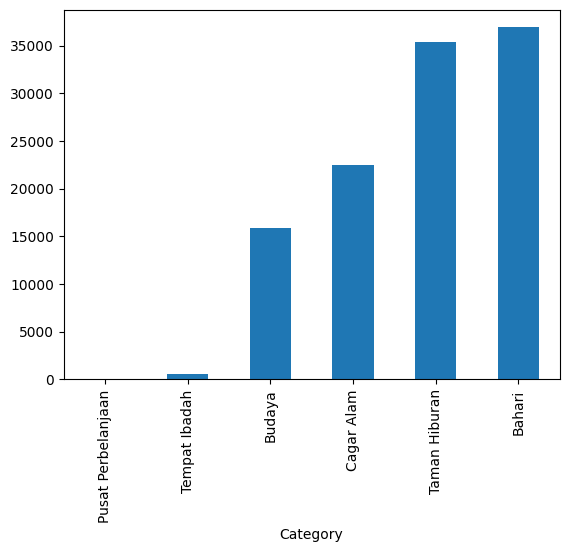

In [21]:
tourism_category_price = df_tourism.groupby('Category')['Price']
tourism_category_price.mean().sort_values().plot(kind='bar'), tourism_category_price.describe()

In [23]:
df_transaction = pd.merge(df_transaction, df_tourism[['Place_Id', 'Category', 'City']], on='Place_Id', how='left')

<Axes: >

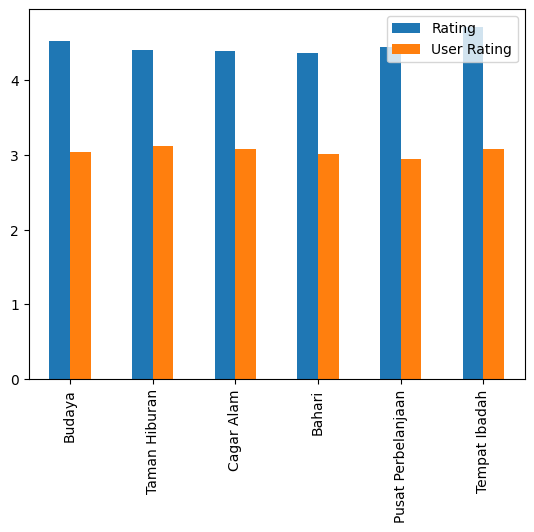

In [24]:
pd.DataFrame(index=df_tourism['Category'].unique(), data={
    'Rating': df_tourism.groupby('Category')['Rating'].mean().sort_values(),
    'User Rating': df_transaction.groupby('Category')['Place_Ratings'].mean().sort_values(),
  }).plot(kind='bar')

<Axes: xlabel='Category,Place_Ratings'>

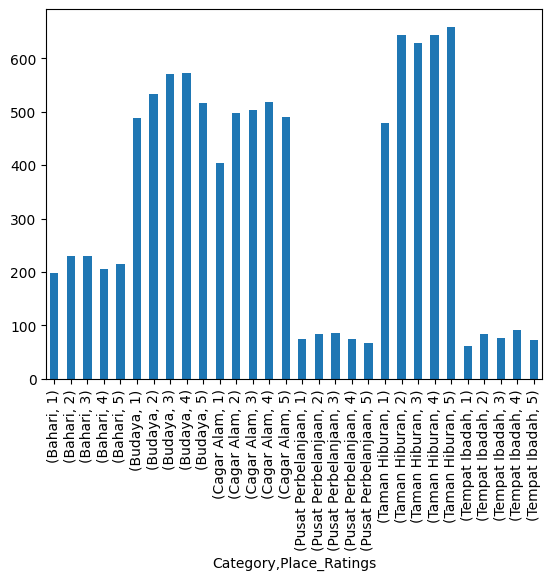

In [25]:
df_transaction.groupby('Category')['Place_Ratings'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='Category'>

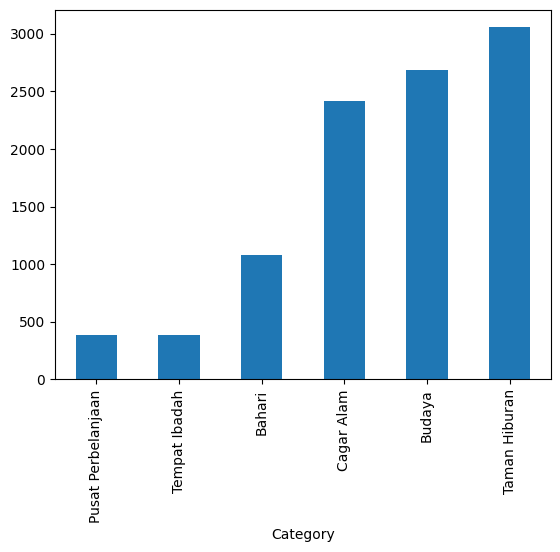

In [26]:
df_transaction.groupby('Category')['Place_Ratings'].count().sort_values().plot(kind='bar')

(<Axes: xlabel='City'>,
             count          mean            std  ...      50%      75%       max
 City                                            ...                            
 Bandung     124.0  24931.451613   48277.034832  ...  10000.0  25000.0  375000.0
 Jakarta      84.0  45130.952381  115657.343905  ...   4500.0  25000.0  900000.0
 Semarang     57.0  17017.543860   34908.293748  ...   5000.0  15000.0  200000.0
 Surabaya     46.0  10195.652174   24540.777462  ...      0.0   8750.0  125000.0
 Yogyakarta  126.0  19456.349206   55219.055401  ...   5000.0  10000.0  500000.0
 
 [5 rows x 8 columns])

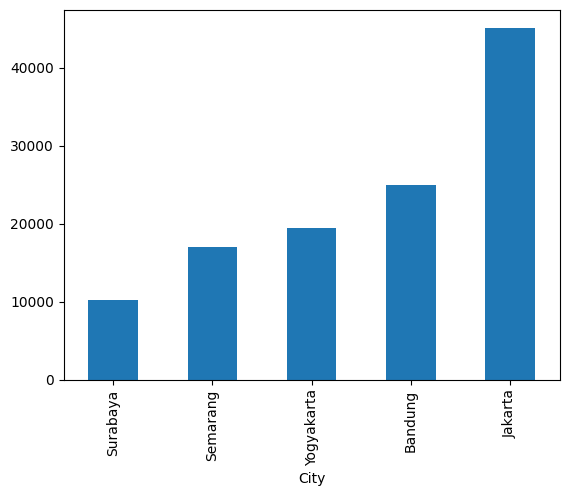

In [27]:
tourism_city_price = df_tourism.groupby('City')['Price']
tourism_city_price.mean().sort_values().plot(kind='bar'), tourism_city_price.describe()

In [ ]:
pd.DataFrame(index=df_tourism['City'].unique(), data={
    'Rating': df_tourism.groupby('City')['Rating'].mean().sort_values(),
    'User Rating': df_transaction.groupby('City')['Place_Ratings'].mean().sort_values(),
  }).plot(kind='bar')

<Axes: xlabel='City,Place_Ratings'>

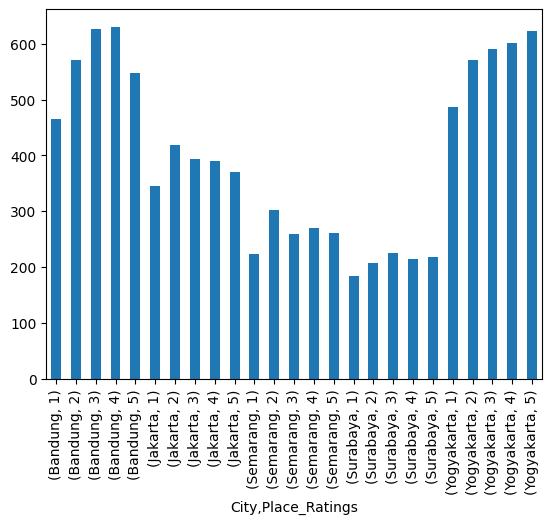

In [29]:
df_transaction.groupby('City')['Place_Ratings'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='City'>

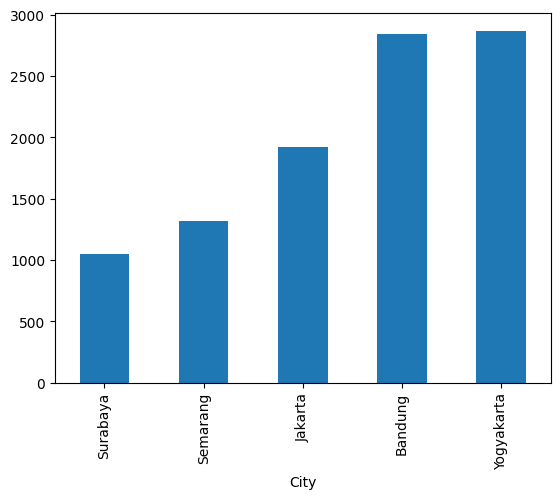

In [30]:
df_transaction.groupby('City')['Place_Ratings'].count().sort_values().plot(kind='bar')

<Axes: xlabel='Category'>

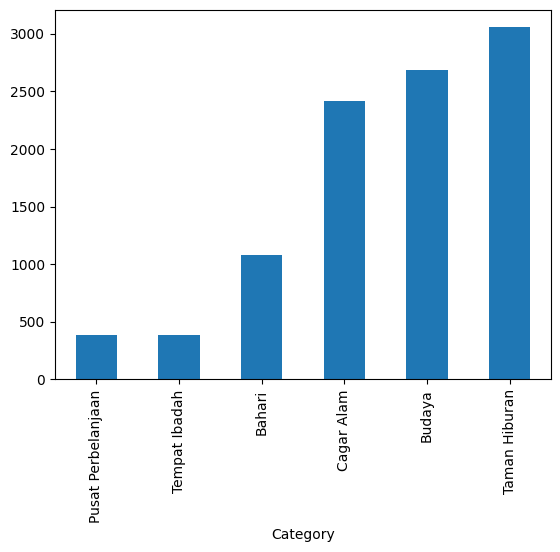

In [31]:
df_transaction.groupby('Category')['User_Id'].count().sort_values().plot(kind='bar')

<Axes: xlabel='City'>

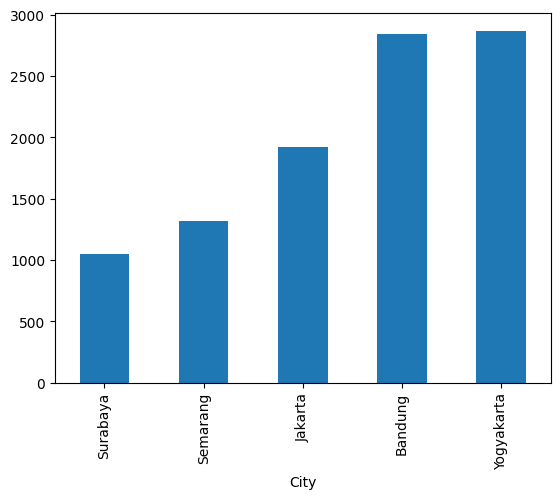

In [32]:
df_transaction.groupby('City')['User_Id'].count().sort_values().plot(kind='bar')

<Axes: >

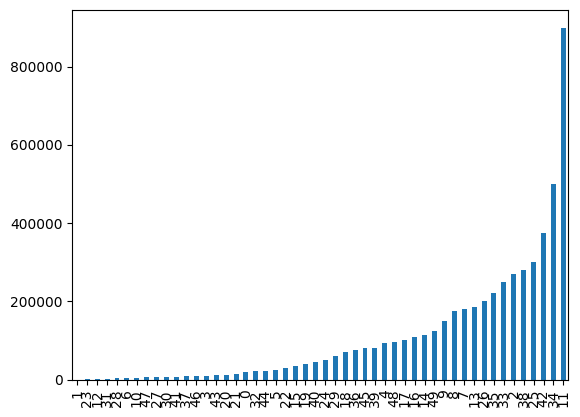

In [33]:
pd.Series(df_tourism['Price'].unique()).sort_values().plot(kind='bar')

In [34]:
print('Jumlah Tempat Wisata: ', len(df_tourism['Place_Id'].unique()))
print('Jumlah User: ', len(df_user['User_Id'].unique()))
print('Jumlah Rating User: ', len(df_transaction['User_Id'].unique()))
print('Jumlah Rating Tempat Wisata: ', len(df_transaction['Place_Id'].unique()))
print('Jumlah Rating: ', len(df_transaction))
print('Jumlah Paket: ', len(df_package))

Jumlah Tempat Wisata:  437
Jumlah User:  300
Jumlah Rating User:  300
Jumlah Rating Tempat Wisata:  437
Jumlah Rating:  10000
Jumlah Paket:  100


In [35]:
pd.DataFrame(data={'Jumlah': [
  len(df_tourism[df_tourism['Price'] == 0]),
  len(df_tourism[(df_tourism['Price'] <= 100000) & (df_tourism['Price'] > 0)]),
  len(df_tourism[(df_tourism['Price'] <= 200000) & (df_tourism['Price'] > 100000)]),
  len(df_tourism[df_tourism['Price'] > 200000])
]}, index=('Gratis', 'Murah', 'Lumayan', 'Mahal'))

,Jumlah
Gratis,137
Murah,276
Lumayan,16
Mahal,8


Fitur Price dapat diesktrak menjadi fitur baru yaitu Budget sebagai indikasi pengaluaran uang dalam bentuk teks

```
Price == 0 (Gratis)
Price > 0 & Price <= 100000 (Murah)
Price > 100000 & Price <= 200000 (Lumayan)
Price > 200000 (Mahal)
```

In [36]:
def set_budget(price):
  if price == 0:
    return 'Gratis'
  elif price <= 100000:
    return 'Murah'
  elif price <= 20000:
    return 'Lumayan'
  else:
    return 'Mahal'

In [37]:
df_tourism['Budget'] = df_tourism['Price'].apply(set_budget)
df_tourism.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long,Budget
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,Murah
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,Gratis
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,Mahal
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,Murah
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,Murah


In [38]:
df_tourism.isna().sum()

Place_Id       0
Place_Name     0
Description    0
Category       0
City           0
Price          0
Rating         0
Coordinate     0
Lat            0
Long           0
Budget         0
dtype: int64

Hanya fitur Time_Minute yang terdapat null, tetapi fitur itu tidak akan dipakai jadi bisa dibiarkan saja

# Model & Evaluation

Untuk Content Based Filtering teknik yang digunakan yaitu cosine similiarity dan metrik yang digunakan yaitu precission terhadap rekomendasi yang diberikan.

Formula precission:
\begin{array}{rcl}
precission & = & \dfrac{\text{# Relevant recommendations}}{\text{# Top items recommended}}
\end{array}

Untuk Collaborative Filtering teknik yang akan digunakan yaitu embedding dan metrik yang digunakan yaitu RMSE (_Root Mean Squared Error_)

Formula RMSE:

\begin{array}{rcl}
\text{RMSE}(y, \hat{y}) = \sqrt{\frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}}
\end{array}


## Content Based Filtering

Content yang akan digunakan sebagai filtering akan menggunakan beberapa fitur yang akan digabung menjadi sebuah "_Metadata_". Fitur yang akan digunakan yaitu Category, City, Budget dan Description.

In [39]:
features = ['Category', 'City', 'Budget', 'Description']

df_tourism['Metadata'] = ''

for feature in features:
  df_tourism['Metadata'] += (df_tourism[feature].str.lower() + ' ')

df_tourism['Metadata']

0      budaya jakarta murah monumen nasional atau yan...
1      budaya jakarta gratis kota tua di jakarta, yan...
2      taman hiburan jakarta mahal dunia fantasi atau...
3      taman hiburan jakarta murah taman mini indones...
4      taman hiburan jakarta murah atlantis water adv...
                             ...                        
432    budaya surabaya murah museum negeri mpu tantul...
433    taman hiburan surabaya gratis taman bungkul ad...
434    taman hiburan surabaya gratis air mancur menar...
435    taman hiburan surabaya gratis taman flora adal...
436    tempat ibadah surabaya murah gereja katolik ke...
Name: Metadata, Length: 437, dtype: object

In [40]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(df_tourism['Metadata'].fillna(''))

tfidf_matrix.shape

(437, 6526)

Formula cosine similarity:

$Cosine(x,y) = \frac{x \cdot y}{|x||y|}$

In [42]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(437, 437)

In [43]:
tourism = pd.Series(df_tourism.index, index=df_tourism['Place_Name']).drop_duplicates()
tourism

Place_Name
Monumen Nasional                               0
Kota Tua                                       1
Dunia Fantasi                                  2
Taman Mini Indonesia Indah (TMII)              3
Atlantis Water Adventure                       4
                                            ... 
Museum Mpu Tantular                          432
Taman Bungkul                                433
Taman Air Mancur Menari Kenjeran             434
Taman Flora Bratang Surabaya                 435
Gereja Perawan Maria Tak Berdosa Surabaya    436
Length: 437, dtype: int64

In [67]:
def get_recommendations_by_place(place, k = 5):
  index = tourism[place]
  category = df_tourism[df_tourism['Place_Id'] == index]['Category'].values[0]
  print("Jika Anda suka tempat wisata {} dengan tema {}, mungkin beberapa tempat ini cocok untuk Anda\n\n".format(place, category))
  similarities = cosine_sim[index]
  similarity_scores = list(enumerate(similarities))
  similarity_scores = sorted(similarity_scores , key=lambda x: x[1], reverse = True)
  similarity_scores = similarity_scores[1:k + 1]
  similar_indexes = [x[0] for x in similarity_scores]

  recommend_places = df_tourism.iloc[similar_indexes]

  return recommend_places[['Place_Name', 'Category']]

In [68]:
get_recommendations_by_place('Kota Tua', 10)

Jika Anda suka tempat wisata Kota Tua dengan tema Budaya, mungkin beberapa tempat ini cocok untuk Anda




,Place_Name,Category
124,Alun-alun Utara Keraton Yogyakarta,Budaya
95,Alun Alun Selatan Yogyakarta,Taman Hiburan
117,Museum Sonobudoyo Unit I,Budaya
226,Alun-Alun Kota Bandung,Taman Hiburan
40,Museum Bahari Jakarta,Budaya
41,Museum Seni Rupa dan Kramik,Budaya
20,Museum Wayang,Budaya
379,Masjid Agung Ungaran,Tempat Ibadah
16,Museum Fatahillah,Budaya
23,Museum Nasional,Budaya


Hasil rekomendasi menunjukan hasil yang cukup baik dalam content based filtering.

Hasil diatas menunjukan tingkat presisi yang tinggi untuk kategori tempat wisata.

$p = \frac{7}{10} = 70 \text{%}$

## Collaborative Filtering

In [69]:
df_transaction.head()

,User_Id,Place_Id,Place_Ratings,Category,City
0,1,179,3,Budaya,Yogyakarta
1,1,344,2,Bahari,Semarang
2,1,5,5,Taman Hiburan,Jakarta
3,1,373,3,Budaya,Semarang
4,1,101,4,Budaya,Yogyakarta


In [70]:
df_transaction['Place_Ratings'].describe()

count    10000.000000
mean         3.066500
std          1.379952
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Place_Ratings, dtype: float64

In [71]:
df_transaction = df_transaction.sample(frac=1, random_state=112)
df_transaction

,User_Id,Place_Id,Place_Ratings,Category,City
1705,53,43,2,Taman Hiburan,Jakarta
1358,42,386,2,Cagar Alam,Semarang
1576,49,90,1,Taman Hiburan,Yogyakarta
1292,40,298,5,Cagar Alam,Bandung
2112,65,312,4,Cagar Alam,Bandung
...,...,...,...,...,...
684,22,37,5,Taman Hiburan,Jakarta
5317,161,52,5,Budaya,Jakarta
2369,73,133,3,Taman Hiburan,Yogyakarta
7642,230,171,1,Budaya,Yogyakarta


In [72]:
min_rating = min(df_transaction['Place_Ratings'])
max_rating = max(df_transaction['Place_Ratings'])

X = df_transaction[['User_Id', 'Place_Id']].values
y = df_transaction['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split data 8:2 train:val
train_indices = int(.8 * df_transaction.shape[0])
X_train, X_val, y_train, y_val = [
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
]

print(X, y)

[[ 53  43]
 [ 42 386]
 [ 49  90]
 ...
 [ 73 133]
 [230 171]
 [  9 196]] [0.25 0.25 0.   ... 0.5  0.   0.75]


In [73]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = Embedding(num_users, 1)
    self.place_embedding = Embedding(
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = Embedding(num_place, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    place_vector = self.place_embedding(inputs[:, 1])
    place_bias = self.place_bias(inputs[:, 1])

    dot_user_resto = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_resto + user_bias + place_bias

    return tf.nn.sigmoid(x)

In [74]:
num_users = len(df_transaction['User_Id'])
num_place = len(df_transaction['Place_Id'])

model = RecommenderNet(num_users, num_place, 32)

model.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate = 0.001),
    metrics = [RootMeanSquaredError()]
)

In [75]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 8,
    epochs = 72,
    validation_data = (X_val, y_val)
)

Epoch 1/72
1000/1000 [==============================] - 6s 5ms/step - loss: 0.6928 - root_mean_squared_error: 0.3445 - val_loss: 0.6934 - val_root_mean_squared_error: 0.3479
Epoch 2/72
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6871 - root_mean_squared_error: 0.3403 - val_loss: 0.6940 - val_root_mean_squared_error: 0.3483
Epoch 3/72
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6816 - root_mean_squared_error: 0.3363 - val_loss: 0.6958 - val_root_mean_squared_error: 0.3495
Epoch 4/72
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6770 - root_mean_squared_error: 0.3329 - val_loss: 0.6972 - val_root_mean_squared_error: 0.3505
Epoch 5/72
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6725 - root_mean_squared_error: 0.3296 - val_loss: 0.6977 - val_root_mean_squared_error: 0.3508
Epoch 6/72
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6702 - root_mean_squared_error: 0.3279 - val_loss: 0

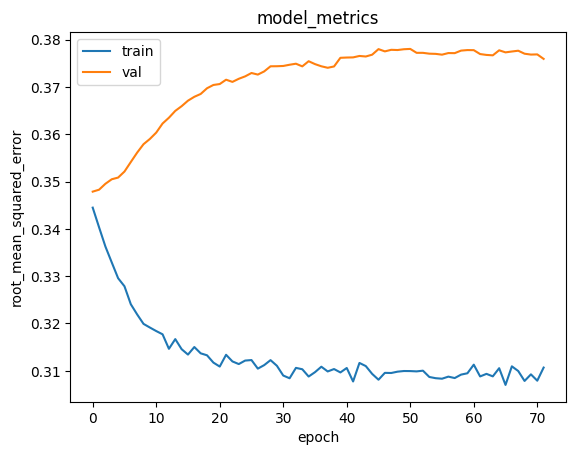

In [76]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [138]:
def get_recommendation_by_user(user_id, k = 5):
  visited = df_transaction[df_transaction['User_Id'] == user_id]
  not_visited = df_tourism[~df_tourism['Place_Id'].isin(visited['Place_Id'].values)]['Place_Id']

  # most_visited = df_transaction[(df_transaction['Place_Id'].isin(visited['Place_Id'].values)) & (df_transaction['User_Id'] == user_id)]['Category'].value_counts()

  user_with_not_visited = np.array([[user_id, x] for x in not_visited])

  ratings = model.predict(user_with_not_visited).flatten()

  top_ratings_indices = ratings.argsort()[-k:][::-1]
  recommended_place_ids = df_tourism[df_tourism['Place_Id'].isin(top_ratings_indices)]

  print('Tempat dengan rating tertinggi dari user ', user_id, '\n\n')
  top_user_places = visited.sort_values(by='Place_Ratings', ascending=False).head(5)['Place_Id']
  for top_place in df_tourism[df_tourism['Place_Id'].isin(top_user_places)].itertuples():
    print(top_place.Place_Name, ':', top_place.Category)

  print(f'\n\nTop {k} Rekomendasi tempat wisata')
  for top_recommend in recommended_place_ids.itertuples():
    print(top_recommend.Place_Name, ':', top_recommend.Category)

  return recommended_place_ids[['Place_Name', 'Category']]

In [139]:
get_recommendation_by_user(14, 10)

13/13 [==============================] - 0s 1ms/step
Tempat dengan rating tertinggi dari user  14 


Margasatwa Muara Angke : Cagar Alam
Situs Warungboto : Taman Hiburan
Upside Down World Bandung : Taman Hiburan
Gua Pawon : Cagar Alam
Semarang Chinatown : Budaya


Top 10 Rekomendasi tempat wisata
Taman Situ Lembang : Taman Hiburan
Monumen Batik Yogyakarta : Budaya
Gumuk Pasir Parangkusumo : Taman Hiburan
Water Park Bandung Indah : Taman Hiburan
Sendang Geulis Kahuripan : Cagar Alam
Taman Hutan Raya Ir. H. Juanda : Cagar Alam
Wisata Alam Wana Wisata Penggaron : Cagar Alam
Kampoeng Rawa : Cagar Alam
Benteng Pendem : Budaya
Semarang Chinatown : Budaya


,Place_Name,Category
46,Taman Situ Lembang,Taman Hiburan
101,Monumen Batik Yogyakarta,Budaya
127,Gumuk Pasir Parangkusumo,Taman Hiburan
290,Water Park Bandung Indah,Taman Hiburan
298,Sendang Geulis Kahuripan,Cagar Alam
311,Taman Hutan Raya Ir. H. Juanda,Cagar Alam
356,Wisata Alam Wana Wisata Penggaron,Cagar Alam
367,Kampoeng Rawa,Cagar Alam
369,Benteng Pendem,Budaya
375,Semarang Chinatown,Budaya
